### Wifi features

This this is the code to generate the wifi features available in [this dataset](https://www.kaggle.com/devinanzelmo/indoor-navigation-and-location-wifi-features). Using these features can get a score below 14. For an example notebook using them see [this notebook](https://www.kaggle.com/devinanzelmo/wifi-features-lightgbm-starter). They only uses waypoints, wifi and timestamp data to generate solution. See this [forum post](https://www.kaggle.com/c/indoor-location-navigation/discussion/215445) for an outline of this solution method, and methods of improvement.

There are `break`'s inserted into loops which need to be removed to get this to run. Right now data is written to current working directory. This takes 2-4 hours to run depending on hard drive etc. There is a lot of room for improvement speeding up feature generation. 

**Update:** I added one line that creates a column for the path filename, this allows for a groupkfold crossvalidation. 


In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import json 
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

In [2]:
base_path = '.'

# pull out all the buildings actually used in the test set, given current method we don't need the other ones
ssubm = pd.read_csv('sample_submission.csv')

# only 24 of the total buildings are used in the test set, 
# this allows us to greatly reduce the intial size of the dataset

ssubm_df = ssubm["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
used_buildings = sorted(ssubm_df[0].value_counts().index.tolist())

# dictionary used to map the floor codes to the values used in the submission file. 
floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2, "F4":3, "F5":4, "F6":5, "F7":6,"F8":7, "F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5, "7F":6, "8F": 7, "9F":8}

In [3]:
ssubm_df.head()

,0,1,2
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326
3,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000018763
4,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000022328


In [4]:
print(len(used_buildings))
#used_buildings

24


In [5]:
createdBuildingPath = glob.glob(f"referencePublicNotebooks/wiFiFeatures/*.csv")
len(createdBuildingPath)

20

In [6]:
createdBuildingNames =  [x.split('/')[-1].replace('_train.csv', '') for x in createdBuildingPath] 

In [7]:
remaining = list(set(used_buildings) - set(createdBuildingNames))

In [8]:
remaining.sort()

In [9]:
remaining

['5d27075f03f801723c2e360f',
 '5d2709c303f801723c3299ee',
 '5da958dd46f8266d0737457b',
 '5dc8cea7659e181adb076a3f']

In [4]:
wifiDataMap = { '0' :"sys_ts", '1':"type", '2':"ssid", '3':"bssid", '4':"rssi", '5':"freq", '6':"lastseen"}

In [5]:
ssubm_df.head(3)

,0,1,2
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326


```python
%%time
# get only the wifi bssid that occur over 1000 times(this number can be experimented with)
# these will be the only ones used when constructing features
bssid = dict()

for building in used_buildings:
    #break
    folders = sorted(glob.glob(os.path.join(base_path,'train/'+building+'/*')))
    print(building)
    wifi = list()
    for folder in folders:
        floor = floor_map[folder.split('/')[-1]]
        files = glob.glob(os.path.join(folder, "*.txt"))
        for file in files:
            with open(file) as f:
                txt = f.readlines()
                for e, line in enumerate(txt):
                    tmp = line.strip().split()
                    if tmp[1] == "TYPE_WIFI":
                        wifi.append(tmp)
    df = pd.DataFrame(wifi)
    #top_bssid = df[3].value_counts().iloc[:500].index.tolist()
    value_counts = df[3].value_counts()
    top_bssid = value_counts[value_counts > 1000].index.tolist()
    print(len(top_bssid))
    bssid[building] = top_bssid
    del df
    del wifi
    gc.collect()
```

In [6]:
#with open("bssid_1000.json", "w") as f:
#    json.dump(bssid, f)

with open("referencePublicNotebooks/bssid_1000.json") as f:
    bssid = json.load(f)

In [7]:
building = used_buildings[0]
folders = sorted(glob.glob(os.path.join(base_path,'train', building +'/*')))
dfs = list()
index = sorted(bssid[building])
dt_index = [x+ "_dt" for x in index]
print(f"building = {building}")
folder = folders[0]
print(f"folder = {folder}")
floor = floor_map[folder.split('/')[-1]]
print(f"floor = {floor}")
files = glob.glob(os.path.join(folder, "*.txt"))
file =files[0]
print(f"file = {file}")

building = 5a0546857ecc773753327266
folder = ./train/5a0546857ecc773753327266/B1
floor = -1
file = ./train/5a0546857ecc773753327266/B1/5e157323a280850006f3d017.txt


In [8]:
wifi = list()
waypoint = list()
with open(file) as f:
    txt = f.readlines()
for line in txt:
    line = line.strip().split()
    if line[1] == "TYPE_WAYPOINT":
        waypoint.append(line)
    if line[1] == "TYPE_WIFI":
        wifi.append(line)

df = pd.DataFrame(np.array(wifi))
#df = df.rename(columns=wifiDataMap)
#df = df.drop(labels=[1,2])

# make timestamps as integer
df[0] = df[0].astype(np.int64)

# sort by time
df.sort_values(by=[0],inplace=True)
wifiTimeStamps = df[0].values
print(df.shape)
df.head(3)

(3432, 7)


,0,1,2,3,4,5,6
0,1578462804152,TYPE_WIFI,da39a3ee5e6b4b0d3255bfef95601890afd80709,c08ad78a45798cfe176a42b35c7381ae602711c5,-42,5825,1578462803569
94,1578462804152,TYPE_WIFI,286c4898ff7b20f59030362ee0c3eb505d99e895,3e773353957a7a0e2485090d41de1fa5a65df532,-82,2412,1578462779808
93,1578462804152,TYPE_WIFI,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,8d8caa754528e2b2eee8bf2b6362bc950968c959,-82,5825,1578462788933


In [9]:
waypoint = pd.DataFrame(np.array(waypoint))
waypoint.sort_values(by=[0], inplace=True)
waypoint.head(3)

,0,1,2,3
0,1578462802213,TYPE_WAYPOINT,223.09842,154.77519
1,1578462809093,TYPE_WAYPOINT,224.45633,160.10567
2,1578462820081,TYPE_WAYPOINT,232.462,164.41673


In [10]:
wayPtTimestamps = waypoint[0].values.astype(np.int64)
print(wayPtTimestamps)

[1578462802213 1578462809093 1578462820081 1578462830942 1578462843572]


In [11]:
wifiTimeStamps, wayPtTimestamps

(array([1578462804152, 1578462804152, 1578462804152, ..., 1578462850552,
        1578462850552, 1578462850552]),
 array([1578462802213, 1578462809093, 1578462820081, 1578462830942,
        1578462843572]))

In [12]:
waypointx = waypoint[2].values.astype(float)
waypointy = waypoint[3].values.astype(float)

In [13]:
wifiAPx = np.interp(wifiTimeStamps, wayPtTimestamps, waypointx)
wifiAPy = np.interp(wifiTimeStamps, wayPtTimestamps, waypointy)

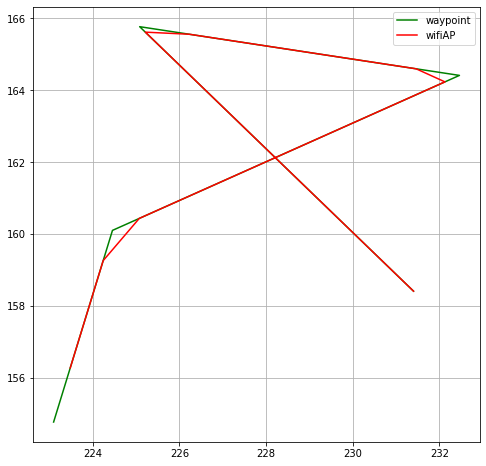

In [14]:
plt.figure(figsize=(8,8))
plt.plot(waypointx, waypointy, 'g', label = 'waypoint')
plt.plot(wifiAPx, wifiAPy, 'r', label = 'wifiAP')
plt.legend()
plt.grid(True)
plt.show()

## Understanding test data

In [ ]:
df[0].unique()

In [ ]:
wifi_points = pd.DataFrame(df.groupby(0).count().index.tolist())

In [ ]:
wifi_points

In [ ]:
def getTimeStampDf(df, currentTimeStamp):
    print(f"currentTimeStamp = {currentTimeStamp}")
    timestampdf = df[df[0] < currentTimeStamp]
    print(f"df within timestamp shape is {timestampdf.shape}")
    print(f"There are {timestampdf[3].nunique()} unique wifi ids in given timestamp")
    uniquedf = timestampdf.drop_duplicates(subset=[3], keep='last')
    uniquedf[6] = (currentTimeStamp - uniquedf[6].astype(np.int64)).astype(float) / 1000.0
    return uniquedf

In [ ]:
def getWiFiIDFeature(uniquedf):
    wifiIDFeature = uniquedf.iloc[:,3:5]
    wifiIDFeature = wifiIDFeature.set_index(3).reindex(index).replace(np.nan, -999).T
    return wifiIDFeature

In [ ]:
def getWiFiDtFeature(uniquedf):
    wifiDtFeature = uniquedf.iloc[:,[3,6]]
    wifiDtFeature = wifiDtFeature.set_index(3).reindex(index).replace(np.nan, 1000.0).T
    return wifiDtFeature

In [ ]:
uniquedf = getTimeStampDf(df, wayPtTimestamps[1])

In [ ]:
a = getWiFiIDFeature(uniquedf)

In [ ]:
b = getWiFiDtFeature(uniquedf)

In [ ]:
(a.columns.values == b.columns.values).all()

In [ ]:
currentTimeStamp  = wayPtTimestamps[1]


In [ ]:
uniquedf = timestampdf.drop_duplicates(subset=[3], keep='last')
print(uniquedf.shape)
uniquedf.head()

In [ ]:
uniquedf[6] = (currentTimeStamp - uniquedf[6].astype(np.int64)).astype(float) / 1000.0
uniquedf.head()

In [ ]:
wifiIDFeature = uniquedf.iloc[:,3:5]
wifiIDFeature = wifiIDFeature.set_index(3).reindex(index).replace(np.nan, -999).T

In [ ]:
wifiIDFeature.head()

In [ ]:
wifiDtFeature = uniquedf.iloc[:,[3,6]]
wifiDtFeature = wifiDtFeature.set_index(3).reindex(index).replace(np.nan, 1000.0).T
wifiDtFeature.head(3)

In [ ]:
df[5].unique()

In [ ]:
print(np.array(waypoint).shape)
print(np.array(waypoint))

In [ ]:
# generate a feature, and label for each wifi block
for gid, g in df.groupby(0):
    dists = list()
    for e, k in enumerate(waypoint):
        dist = abs(int(gid) - int(k[0]))
        dists.append(dist)
    nearest_wp_index = np.argmin(dists)
    g = g.drop_duplicates(subset=3)  
    break

In [ ]:
g.head(3)

In [ ]:
def getDtFeature(df):
    dtFeat = df.iloc[:,[0,3,6]]
    dtFeat.loc[:,3] = dtFeat.loc[:,3].apply(lambda x: f"{x}_dt")
    dtFeat.loc[:,4] = (dtFeat.loc[:, 0].astype(float) - dtFeat.loc[:, 6].astype(float)) / 1000.0
    dtFeat = dtFeat.drop(columns=[0,6]).set_index(3).reindex(dt_index).replace(np.nan, 100.0).T
    return dtFeat

In [ ]:
def getWiFiIDFeature(df):
    wiFiIDFeat = df.iloc[:,3:5]
    wiFiIDFeat = wiFiIDFeat.set_index(3).reindex(index).replace(np.nan, -999).T
    return wiFiIDFeat

In [ ]:
wiFiIDFeat = getWiFiIDFeature(g)
dtFeat = getDtFeature(g)
feat = pd.concat([wiFiIDFeat, dtFeat], axis=1)
print(feat.shape)

In [ ]:
feat.shape

In [ ]:
feat.head()

In [ ]:
feat["x"] = float(waypoint[nearest_wp_index][2])
feat["y"] = float(waypoint[nearest_wp_index][3])
feat["f"] = floor
feat["path"] = file.split('/')[-1].split('.')[0] # useful for crossvalidation
dfs.append(feat)

In [ ]:
feat.head()